In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

tf.enable_eager_execution()

%matplotlib inline

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Activation Functions

In [2]:
x = np.linspace(-10, 10)

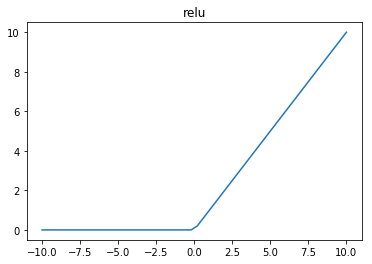

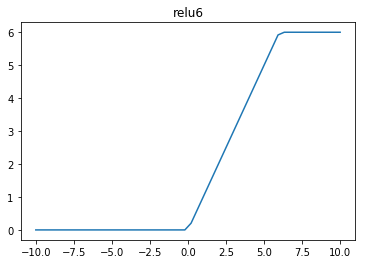

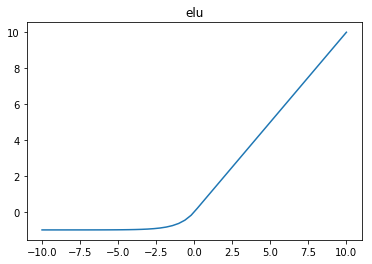

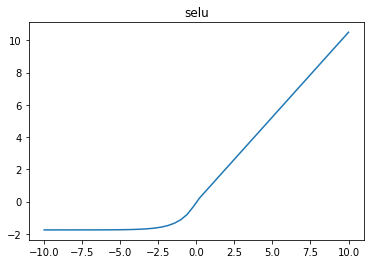

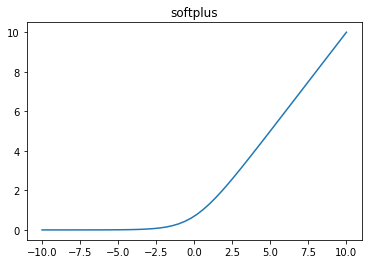

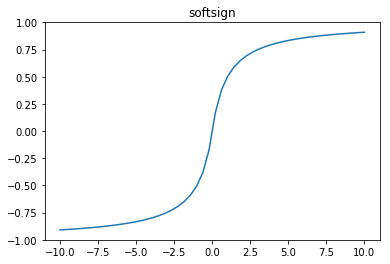

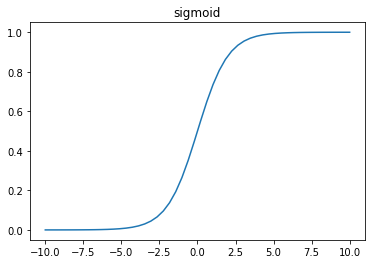

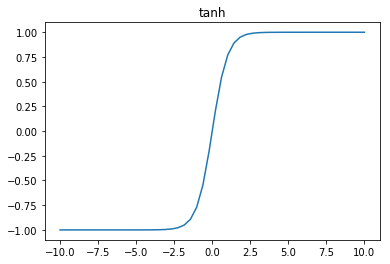

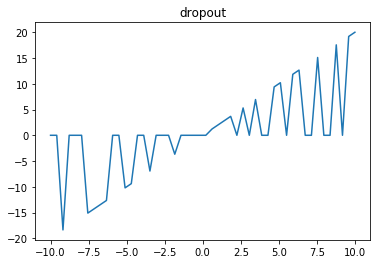

In [3]:
from functools import partial

for f in [
        tf.nn.relu,
        tf.nn.relu6,
        tf.nn.elu,
        tf.nn.selu,
        tf.nn.softplus,
        tf.nn.softsign,
        tf.sigmoid,
        tf.tanh,
        partial(tf.nn.dropout, keep_prob=.5),
        ]:
    y = f(x)
    plt.figure()
    name = f.__name__ if hasattr(f, '__name__') else f.func.__name__
    plt.title(name)
    plt.plot(x, y)

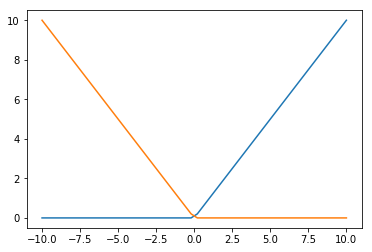

In [4]:
y = tf.nn.crelu(x)
plt.plot(x, y[:len(x)], x, y[len(x):])

(1, 768, 1024, 3)


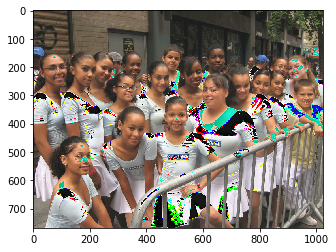

In [5]:
img = tf.image.decode_jpeg(open('test.jpg', 'rb').read())
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.expand_dims(img, 0)
print(img.shape)
y = tf.nn.bias_add(img, [.1, .1, .1])
im = tf.squeeze(y, 0)
plt.imshow(im)

# Convolution

名字模式

conv2d: Arbitrary filters that can mix channels together.
所有通道一起计算

depthwise_conv2d: Filters that operate on each channel independently.
每个通道单独计算

separable_conv2d: A depthwise spatial filter followed by a pointwise filter.
通道单独计算后，再每个点单独计算

atrous_conv2d
空洞卷积

{depthwise, separable, atrous}_conv{1, 2, 3}d_transpose

convolution
n维卷积

https://docs.gimp.org/en/plug-in-convmatrix.html

## 数字

In [6]:
one = np.ones([9])
blocks = tf.constant([(one * i) for i in range(9)])
big = tf.reshape(blocks, [1, 3, 3, 9])
x = tf.depth_to_space(big, 3)
print(x.shape)
print(tf.squeeze(x))

(1, 9, 9, 1)
tf.Tensor(
[[0. 0. 0. 1. 1. 1. 2. 2. 2.]
 [0. 0. 0. 1. 1. 1. 2. 2. 2.]
 [0. 0. 0. 1. 1. 1. 2. 2. 2.]
 [3. 3. 3. 4. 4. 4. 5. 5. 5.]
 [3. 3. 3. 4. 4. 4. 5. 5. 5.]
 [3. 3. 3. 4. 4. 4. 5. 5. 5.]
 [6. 6. 6. 7. 7. 7. 8. 8. 8.]
 [6. 6. 6. 7. 7. 7. 8. 8. 8.]
 [6. 6. 6. 7. 7. 7. 8. 8. 8.]], shape=(9, 9), dtype=float64)


In [7]:
y = tf.nn.conv2d(
    x,
    filter=np.ones([3, 3, 1, 1]),
    strides=[1, 3, 3, 1],
    padding="VALID")
print(y.shape)
print(tf.squeeze(y))

(1, 3, 3, 1)
tf.Tensor(
[[ 0.  9. 18.]
 [27. 36. 45.]
 [54. 63. 72.]], shape=(3, 3), dtype=float64)


In [8]:
y = tf.nn.atrous_conv2d(
    x,
    filters=np.ones([3, 3, 1, 1]),
    rate=2,
    padding='VALID')
print(y.shape)
print(tf.squeeze(y))

(1, 5, 5, 1)
tf.Tensor(
[[12. 15. 18. 21. 24.]
 [21. 24. 27. 30. 33.]
 [30. 33. 36. 39. 42.]
 [39. 42. 45. 48. 51.]
 [48. 51. 54. 57. 60.]], shape=(5, 5), dtype=float64)


## 图片

遇到这个错误，是因为图片类型为uint8，改成float32就好了

    InternalError: Could not find valid device for node name: "Conv2D"

(100, 100, 3)


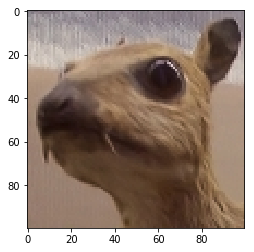

In [20]:
image = tf.image.decode_png(open('Vd-Orig.png', 'rb').read())
image = tf.image.convert_image_dtype(image, tf.float32)
print(image.shape)
plt.imshow(image, cmap='gray')
im = tf.reshape(image, [1, 100, 100, 3])

(1, 100, 100, 1)


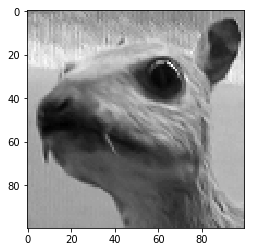

In [10]:
r, g, b = tf.unstack(im, axis=3)
plt.figure()
plt.imshow(tf.squeeze(r), cmap='gray')
r = tf.expand_dims(r, -1)
print(r.shape)

In [11]:
kernel = np.array([
    [0, 1, 0],
    [1, -5, 1],
    [0, 1, 0],
], dtype=np.float32).reshape([3, 3, 1, 1])

kernel2 = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=np.float32).reshape([3, 3, 1, 1])

print(tf.squeeze(kernel))

tf.Tensor(
[[ 0.  1.  0.]
 [ 1. -5.  1.]
 [ 0.  1.  0.]], shape=(3, 3), dtype=float32)


(1, 50, 50, 1)
(50, 50)
(1, 100, 100, 1)
(100, 100)


InvalidArgumentError: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 100, computed = 3spatial_dim: 1 input: 5 filter: 3 output: 100 stride: 2 dilation: 1 [Op:Conv2DBackpropInput] name: conv2d_transpose/

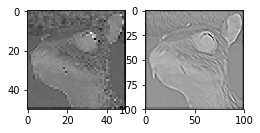

In [12]:
y = tf.nn.conv2d(
    r,
    filter=kernel,
    strides=[1, 2, 2, 1],
    padding='SAME')
print(y.shape)
im = tf.squeeze(y)
print(im.shape)
plt.figure()
plt.subplot(131)
plt.imshow(im, cmap='gray')

y = tf.nn.atrous_conv2d(
    r,
    filters=kernel,
    rate=2,
    padding='SAME')
print(y.shape)
im = tf.squeeze(y)
print(im.shape)
plt.subplot(132)
plt.imshow(im, cmap='gray')

y = tf.nn.conv2d_transpose(
    r,
    filter=kernel,
    output_shape=[1, 5, 5, 1],
    strides=[1, 2, 2, 1],
    padding='SAME')

# Pooling

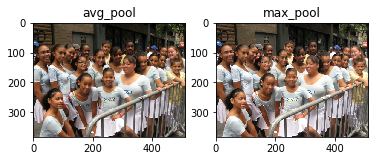

In [13]:
plt.figure()
for i, f in enumerate([
        tf.nn.avg_pool,
        tf.nn.max_pool,
        ], 1):
    y = f(img,
          ksize=[1, 3, 3, 1],
          strides=[1, 2, 2, 1],
          padding='SAME')
    im = tf.squeeze(y)
    plt.subplot(1, 2, i)
    plt.title(f.__name__)
    plt.imshow(im)

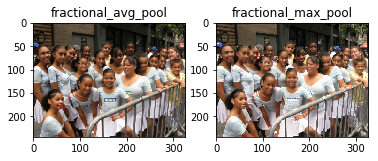

In [14]:
plt.figure()
for i, f in enumerate([
        tf.nn.fractional_avg_pool,
        tf.nn.fractional_max_pool,
        ], 1):
    y = f(img,
          pooling_ratio=[1.0, 3.14, 3.14, 1.0])
    im = tf.squeeze(y.output)
    plt.subplot(1, 2, i)
    plt.title(f.__name__)
    plt.imshow(im)

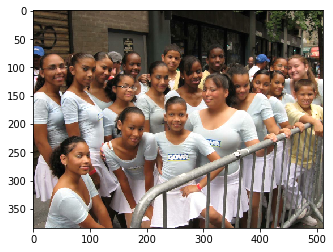

In [15]:
y = tf.nn.max_pool_with_argmax(
    img,
    ksize=[1, 3, 3, 1],
    strides=[1, 2, 2, 1],
    padding='SAME')
im = tf.squeeze(y.output)
plt.imshow(im)

# Morphological filtering


(1, 50, 50, 1)
(1, 50, 50, 1)


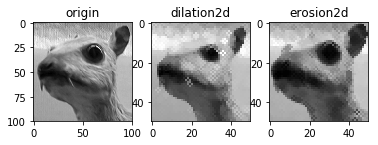

In [16]:
plt.figure()
plt.subplot(1, 3, 1)
plt.title('origin')
plt.imshow(tf.squeeze(r), cmap='gray')

y = tf.nn.dilation2d(
    r,
    filter=tf.squeeze(kernel, -1),
    strides=[1, 2, 2, 1],
    rates=[1, 2, 2, 1],
    padding='SAME')
print(y.shape)
im = tf.squeeze(y)
plt.subplot(1, 3, 2)
plt.title('dilation2d')
plt.imshow(im, cmap='gray')

y = tf.nn.erosion2d(
    r,
    kernel=tf.squeeze(kernel, -1),
    strides=[1, 2, 2, 1],
    rates=[1, 2, 2, 1],
    padding='SAME')
print(y.shape)
im = tf.squeeze(y)
plt.subplot(1, 3, 3)
plt.title('erosion2d')
plt.imshow(im, cmap='gray')

# Normalization

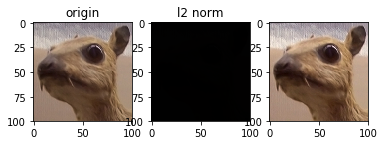

In [32]:
plt.figure()

plt.subplot(1, 3, 1)
plt.title('origin')
plt.imshow(image)

y = tf.nn.l2_normalize(image)
plt.subplot(1, 3, 2)
plt.title('l2 norm')
plt.imshow(y)

im = y.numpy()
im = (im - np.min(im)) / (np.max(im) - np.min(im))
plt.subplot(1, 3, 3)
plt.imshow(im)

In [27]:
x = np.random.random([3, 3])
print(x)
np.min(x)

[[0.78868912 0.05787132 0.08765797]
 [0.74889566 0.09168064 0.79523088]
 [0.38242091 0.82487485 0.53913972]]


0.05787131850900762